In [327]:
from numba.cuda.libdevice import fmax
%matplotlib inline
from scipy import signal
from scipy.io import wavfile
import scipy.integrate
import IPython.display as ipyd
import librosa
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np

In [328]:
minHz = 125
maxHz = 3000
stft_frame_len = 0.033
stft_frame_trans = 0.015
mels_amount = 13


# Comparison Files

In [329]:
def load_plot(path: str):
    #Load and display
    file_sample_rate, file_wav = wavfile.read(path)
    ipyd.display(ipyd.Audio(rate=file_sample_rate, data=file_wav))
    file_n = len(file_wav)

    #plot wav
    plt.figure(figsize=(4,2))
    plt.plot(np.linspace(0, file_n/file_sample_rate, file_n), file_wav)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    # FFT
    plt.figure(figsize=(4,2))
    file_fft = np.fft.fft(file_wav)[minHz:maxHz]
    file_fft_n = len(file_fft)
    plt.plot(np.linspace(0, file_sample_rate*(file_fft_n - 1)/file_fft_n, file_fft_n), np.abs(file_fft))
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()
    return file_sample_rate, file_wav, file_n, file_fft

In [330]:
def spectrum_stft(wave, sample_rate, should_print = False):
    samples_frame = int(stft_frame_len * sample_rate)
    samples_transition = int(stft_frame_trans * sample_rate)
    wave = wave.astype(np.float32)

    # normalize
    wave /= np.max(np.abs(wave),axis=0)

    stft = librosa.stft(wave, n_fft=samples_frame, hop_length=samples_transition)
    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft)),
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    mel_spectrum = librosa.feature.melspectrogram(
        y=wave, sr=sample_rate, n_mels=mels_amount,
        n_fft=samples_frame, hop_length=samples_transition
    )

    log_mel_spectrum = np.log(mel_spectrum)
    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        print(log_mel_spectrum.shape)
        librosa.display.specshow(log_mel_spectrum,
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    return mel_spectrum


In [331]:
def diff_fft(a: np.ndarray, b: np.ndarray, sample_rate: int) -> np.ndarray:

    # diff add
    plt.figure(figsize=(4,2))
    n = len(a)
    x = np.linspace(0, sample_rate*(n - 1)/n, n)
    curve = np.abs(np.abs(a)*4 - np.abs(b))
    plt.plot(x, curve)
    print(np.trapezoid(curve)/100000)

    plt.xlabel("Frequency")
    plt.ylabel("Difference")
    plt.show()

    plt.plot(x, np.abs(a))
    plt.plot(x, np.abs(b))

    idx = np.argwhere(np.diff(np.abs(a) - np.abs(b))).flatten()
    plt.plot(x[idx], np.abs(a)[idx], 'ro')

    plt.show()

    return idx


In [332]:
def cosine_dist(a: np.ndarray, b: np.ndarray):
    a = a.T
    b = b.T

    comp_len = min(len(a), len(b))

    distances = np.zeros(comp_len)
    for i in range(comp_len):
        distances[i] = scipy.spatial.distance.cosine(a[i], b[i])

    return np.average(distances)


## Start

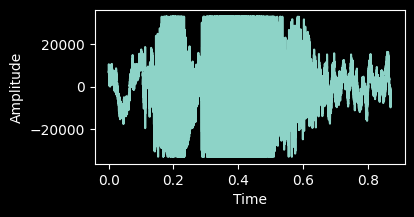

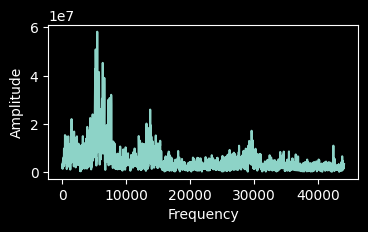

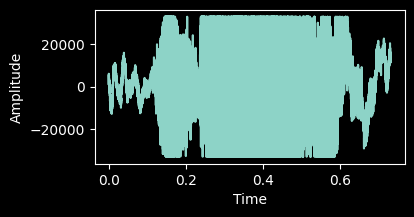

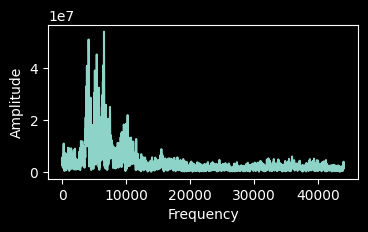

476279.1834743479


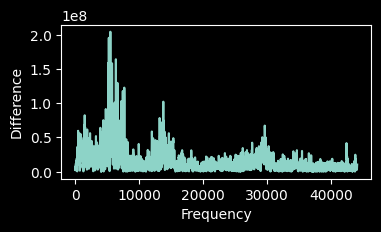

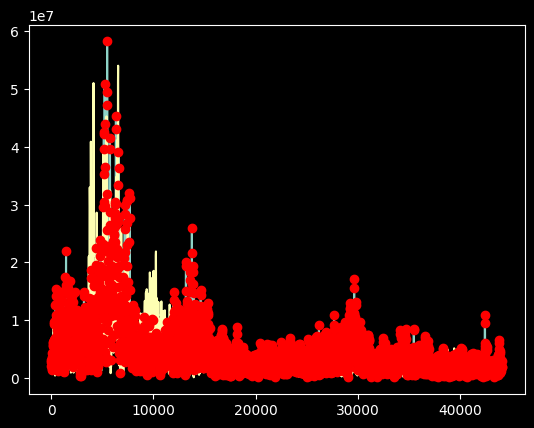

In [333]:
# Load
startFile_sample_rate, startFile_wav, startFile_n, startFile_fft = load_plot("./wav/start.wav")

# load mariusz start
startFileMariusz_sample_rate, startFileMariusz_wav, startFileMariusz_n, startFileMariusz_fft = load_plot("./wav/startMariusz.wav")

diff_fft(startFile_fft, startFileMariusz_fft, startFile_sample_rate)

startFile_mel = spectrum_stft(startFile_wav, startFile_sample_rate)
startFileMariusz_mel= spectrum_stft(startFileMariusz_wav, startFileMariusz_sample_rate)

## Stop

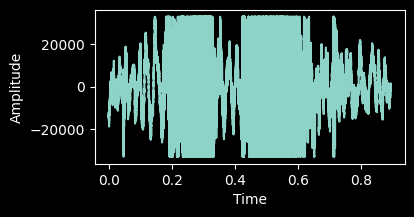

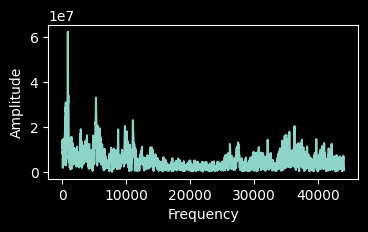

In [334]:
stopFile_sample_rate, stopFile_wav, stopFile_n, stopFile_fft = load_plot("./wav/stop.wav")

stopFile_mel = spectrum_stft(stopFile_wav, stopFile_sample_rate)

## Plus

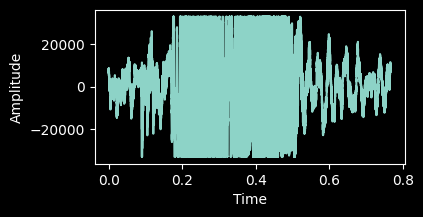

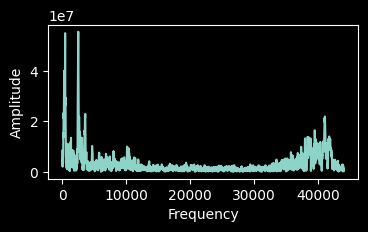

In [335]:
plusFile_sample_rate, plusFile_wav, plusFile_n, plusFile_fft = load_plot("./wav/plus.wav")

plusFile_mel = spectrum_stft(plusFile_wav, plusFile_sample_rate)


## Minus

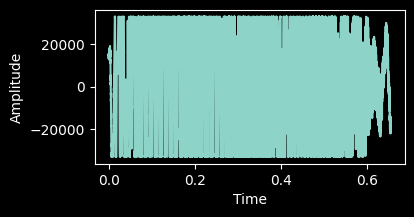

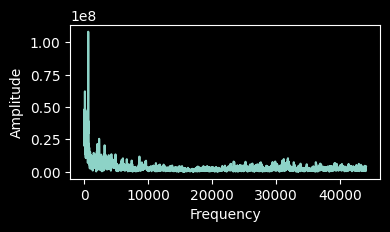

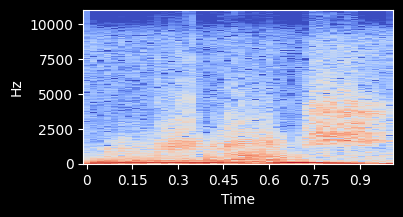

(13, 44)


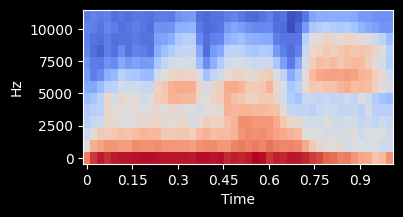

In [336]:
minusFile_sample_rate, minusFile_wav, minusFile_n, minusFile_fft = load_plot("./wav/minus.wav")

minusFile_mel = spectrum_stft(minusFile_wav, minusFile_sample_rate, True)


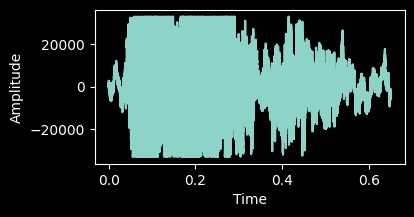

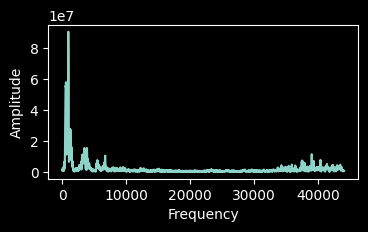

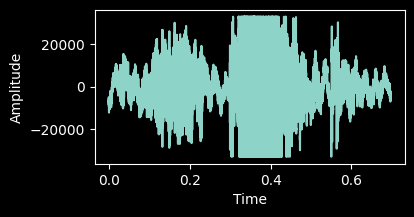

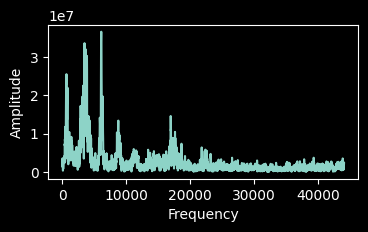

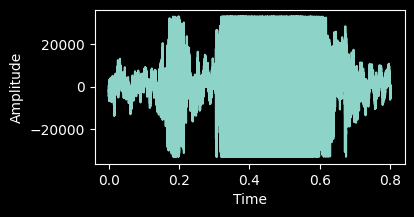

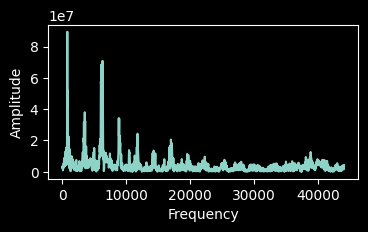

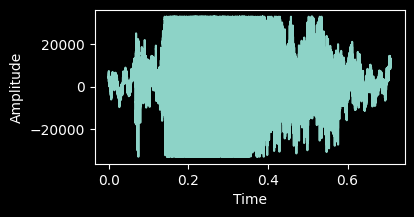

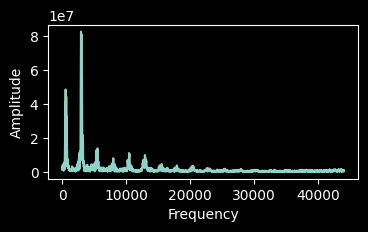

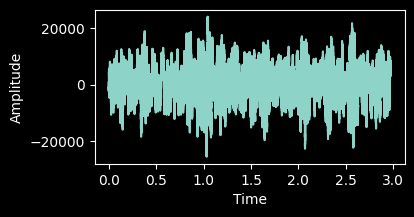

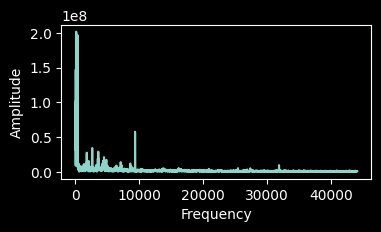

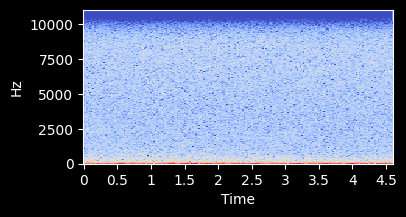

(13, 199)


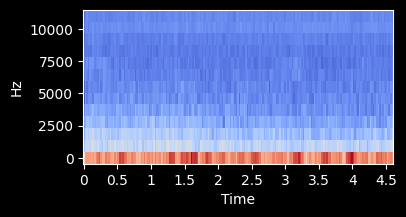

In [337]:
patiMinus_sample_rate, patiMinus_wav, patiMinus_n, patiMinus_fft = load_plot("./wav/patiMinus.wav")
patiMinus_mel = spectrum_stft(patiMinus_wav, patiMinus_sample_rate)

patiStop_sample_rate, patiStop_wav, patiStop_n, patiStop_fft = load_plot("./wav/patiStop.wav")
patiStop_mel = spectrum_stft(patiStop_wav, patiStop_sample_rate)

patiStart_sample_rate, patiStart_wav, patiStart_n, patiStart_fft = load_plot("./wav/patiStart.wav")
patiStart_mel = spectrum_stft(patiStart_wav, patiStart_sample_rate)

patiPlus_sample_rate, patiPlus_wav, patiPlus_n, patiPlus_fft = load_plot("./wav/patiPlus.wav")
patiPlus_mel = spectrum_stft(patiPlus_wav, patiPlus_sample_rate)

noice_sample_rate, noice_wav, noice_n, noice_fft = load_plot("./wav/noice.wav")
noice_mel = spectrum_stft(noice_wav, noice_sample_rate, True)

In [338]:
def find_match(samples, current_mel):
    best_label = None
    best_dist = float("inf")

    dists = []

    for mel, label in samples:
        dist = cosine_dist(mel, current_mel)
        dists.append(dist)
        if dist < best_dist:
            best_dist = dist
            best_label = label

    #print(dists)
    return best_label, best_dist


In [339]:
from collections import deque
import pyaudio
import wave

FORMAT = pyaudio.paInt16
CHUNK = int(stopFile_sample_rate * stft_frame_len)
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=1,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

samples = [(minusFile_mel, "minus"),
           (plusFile_mel, "plus"),
           (stopFile_mel, "stop"),
           (startFile_mel, "start"),
           (patiMinus_mel, "minusP"),
           (patiPlus_mel, "plusP"),
           (patiStart_mel, "startP"),
           (patiStop_mel, "stopP"),
           (noice_mel, "noice")]


buffer_size = max(len(mel) for mel, _ in samples)

try:
    print("* recording")



    frames = []

    for i in range(buffer_size):
        data = stream.read(CHUNK)
        frames.append(data)

    frames = deque(frames, maxlen=len(frames))

    while True:
        data = stream.read(CHUNK)
        frames.append(data)
        full_buffer = b''.join(frames) # Join all chunks into one long byte string
        audio_data = np.frombuffer(full_buffer, dtype=np.int16) # Convert bytes to int16 integers
        frames_mel = spectrum_stft(audio_data.astype(np.float32), stopFile_sample_rate)
        label, num = find_match(samples, frames_mel)
        if label != "noice":
            print(label, " ", num)


finally:
    stream.stop_stream()
    stream.close()
    p.terminate()


* recording
minus   0.00484292877131495
minus   0.015335463244339516
minus   0.02993111569305946
minus   0.035428388365383805
minus   0.03405975267804902
minus   0.05201836495563902
minus   0.07953180732398198
minus   0.08502105186725485
minus   0.08319821234407096
minus   0.08238542490992053
minus   0.09227393207878902
minus   0.09337848424911499
minusP   0.10272441855792341
minus   0.09607941939912994
minus   0.08647127398129167
minus   0.09170573538747327
minus   0.08140888707391147
minus   0.04493264288737856
minus   0.04407083371589924
minus   0.04574762952738795
minus   0.05257572593360112
minus   0.08968393967069428
minus   0.1245295631474462
minus   0.14868383160952864
minus   0.17824100420392794
minus   0.15975398236307606
minus   0.15578136156345235
plusP   0.156836723459178
plusP   0.14996887075489965
minus   0.15529707793531747
minus   0.1549451495039052
minus   0.14447588139566883
minus   0.07826008467838683
minus   0.08446274543630666
minus   0.028701539697318243
minus   

KeyboardInterrupt: 